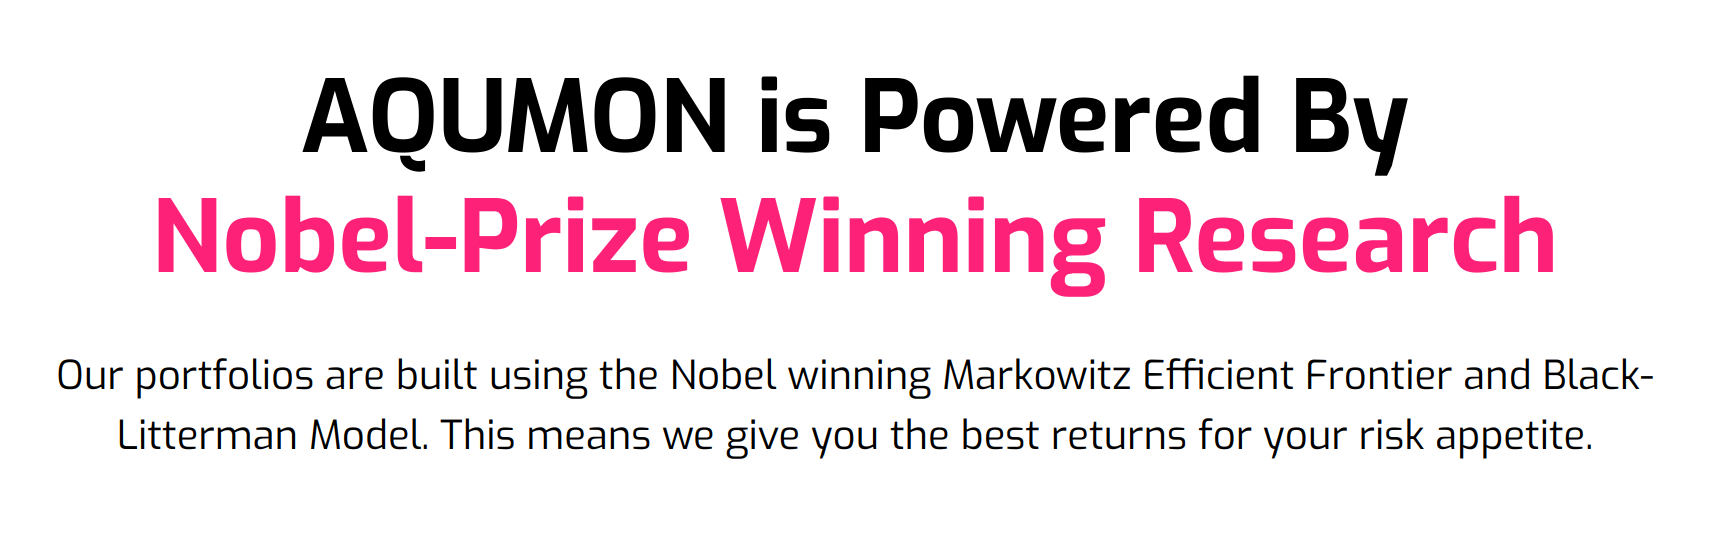

Basic Idea: best returns for certain risk appetite
> Markowitz Efficient Frontier

> Black Litterman Model

# Data

> [Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener)

> From above Link, to select a certain number of tickers by industry | or? ---> find some ETF?

**SPY**
> The SPDR S&P 500 Trust ETF, also known as the SPY ETF, is one of the most popular funds that aims to track the Standard & Poor's 500 Index, which comprises 500 large- and mid-cap U.S. stocks. These stocks are selected by a committee based on the market size, liquidity, and industry.

## Data Source

> From YahooFinance

## Downloading the data —— From YahooFinance

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import pandas as pd
import datetime
import yfinance as yf
import backtrader as bt
import numpy as np

# Date range
start = '2010-01-01'
end = '2020-01-01'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'NBL', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'DHR',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'SPY']
assets.sort()
# Downloading data
prices = yf.download(assets, start = start, end = end)
prices = prices.dropna()

[*********************100%***********************]  25 of 25 completed


In [2]:
prices.head()

Adj Close                                                       \
                  APA        BAX        BMY     CMCSA       CNP        CPB   
Date                                                                         
2009-12-31  86.816673  25.906231  17.794998  6.842078  9.118612  24.138271   
2010-01-04  89.088692  25.734049  18.062807  6.925740  9.124897  24.188265   
2010-01-05  90.140579  25.557457  17.780903  6.831876  9.055768  24.231112   
2010-01-06  91.554268  25.645756  17.773859  6.782901  8.967788  23.959742   
2010-01-07  90.165810  26.060741  17.787954  6.925740  9.055768  23.595522   

                                                        ...     Volume  \
                   DE        DHR        HPQ        JCI  ...        NBL   
Date                                                    ...              
2009-12-31  42.632915  18.528339  17.527159  10.877679  ...  1201400.0   
2010-01-04  44.185638  18.516020  17.847008  11.057550  ...  2227600.0   
2010-01-05  44.020134  18.493845  17.921865  11.002674  ...  3523000.0   
2010-01-06  43.901901  18.528339  17.755129  10.966091  ...  2030200.0   
2010-01-07  44.217175  18.681095  17.761944  11.045349  ...  2110000.0   

                                                                     \
                   NI       PCAR        PSA        SEE          SPY   
Date                                                                  
2009-12-31  3976500.0  1429000.0  1081200.0   769400.0   90637900.0   
2010-01-04  6905600.0  2631700.0  1579100.0   920400.0  118944600.0   
2010-01-05  8784300.0  2299300.0  1131000.0   831400.0  111579900.0   
2010-01-06  7382700.0  3565000.0   832400.0  1334400.0  116074400.0   
2010-01-07  7407200.0  2455700.0  1284100.0  1394900.0  131091100.0   

                                                            
                   TGT         TXT          VZ        ZION  
Date                                                        
2009-12-31   3235900.0   2005800.0   7982700.0   3239800.0  
2010-01-04   4589100.0   3630600.0  16176600.0   3974600.0  
2010-01-05   4760100.0  12121100.0  23722900.0   5605500.0  
2010-01-06   7217400.0   5598300.0  37506400.0  12615200.0  
2010-01-07  12531000.0   5196100.0  25508200.0  24716800.0  

[5 rows x 150 columns]

In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2009-12-31 to 2019-12-31
Columns: 150 entries, ('Adj Close', 'APA') to ('Volume', 'ZION')
dtypes: float64(150)
memory usage: 2.9 MB


# Building the Backtest Function with Backtrader

## Defining Backtest Function

In [6]:
def backtest(datas, strategy, plot=False, **kwargs):
    #Instantiate Cerebro engine
    cerebro = bt.Cerebro()
    #set commission
    cerebro.broker.setcommission(commission=0.005)
    #Add data to cerebro
    for data in datas:
        cerebro.adddata(data)
    #For SharpeRatio
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    #For returns
    cerebro.addanalyzer(bt.analyzers.Returns)
    #For DrawDown
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    #Add strategy
    cerebro.addstrategy(strategy, **kwargs)
    #Add observer (for plotting)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    results = cerebro.run(stdstats=False) #defualt is True
    if plot:
        cerebro.plot(iplot=True, start=1004, end=3000)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'], #compound annual growth rate
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

## Building Data Feeds for Backtesting

In [7]:
# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    if i != 'SPY':
        prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
        prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
        assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))#bt.feeds

# Creating Benchmark bt.feeds        
prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), 'SPY')].dropna()
prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)#bt.feeds

In [8]:
display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2009-12-31,111.440002,112.800003,111.389999,112.769997,90637900.0
2010-01-04,113.330002,113.389999,111.510002,112.370003,118944600.0
2010-01-05,113.629997,113.680000,112.849998,113.260002,111579900.0
2010-01-06,113.709999,113.989998,113.430000,113.519997,116074400.0
2010-01-07,114.190002,114.330002,113.180000,113.500000,131091100.0


# Building Strategies with Backtraderm

## Basic Strategy: Buy and Hold SPY

In [9]:
class BuyAndHold(bt.Strategy):
    def __init__(self):
        self.counter = 0

    def next(self):
        if self.counter >= 1004:
            if not self.getposition(self.data).size:
                self.order_target_percent(self.data, target=1.0)
        self.counter += 1

<IPython.core.display.Javascript object>


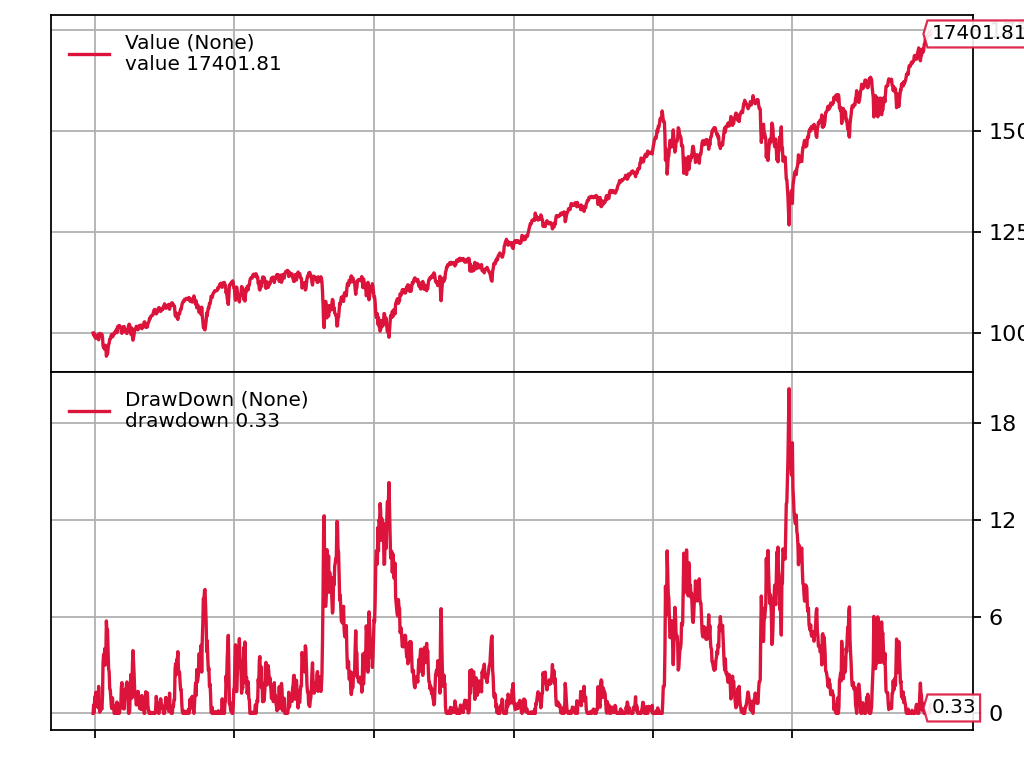

Max Drawdown: 20.15%
CAGR: 5.70%
Sharpe: 0.558


In [10]:
dd, cagr, sharpe = backtest([benchmark], BuyAndHold, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

## Rebalancing Quarterly using [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/portfolio.html?highlight=assets_stats#Portfolio.Portfolio.assets_stats)

In [11]:
pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.drop(columns=['SPY']).dropna()
returns = data.pct_change().dropna()
display(returns.head())

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2.6170%,-0.6646%,1.5050%,1.2228%,0.0689%,0.2071%,3.6421%,-0.0665%,1.8249%,1.6536%,...,1.5420%,2.8082%,0.8453%,0.9374%,-1.6206%,0.7319%,0.3721%,1.2227%,0.4528%,3.8972%
2010-01-05,1.1807%,-0.6862%,-1.5607%,-1.3553%,-0.7576%,0.1771%,-0.3746%,-0.1198%,0.4194%,-0.4963%,...,0.0323%,2.5949%,-0.2579%,1.8028%,0.8237%,-1.0445%,0.3708%,-1.8908%,0.1803%,3.5259%
2010-01-06,1.5683%,0.3455%,-0.0396%,-0.7169%,-0.9715%,-1.1199%,-0.2686%,0.1865%,-0.9304%,-0.3325%,...,-0.6137%,0.9452%,-1.1635%,1.3148%,-0.6066%,-1.9275%,1.9085%,3.4797%,-2.8754%,8.6956%
2010-01-07,-1.5165%,1.6181%,0.0793%,2.1059%,0.9811%,-1.5201%,0.7181%,0.8244%,0.0384%,0.7228%,...,-1.0400%,-1.3451%,-1.2426%,1.3242%,-0.1369%,1.0295%,1.2283%,4.4490%,-0.5953%,11.2000%
2010-01-08,-0.5226%,0.2372%,-1.6640%,-0.2946%,-1.1797%,-0.6356%,2.7273%,1.3981%,0.7471%,0.3313%,...,0.6897%,0.6149%,-0.5298%,0.1307%,-1.8207%,0.4169%,-0.3978%,0.9411%,0.0630%,-1.6187%


In [53]:
# Selecting Dates for Rebalancing

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

# Quarterly Dates
index = [x for x in index if float(x.month) % 3.0 == 0 ] 

# Dates where the strategy will be backtested
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [54]:
index_

[1005,
 1066,
 1129,
 1193,
 1257,
 1318,
 1381,
 1445,
 1509,
 1570,
 1634,
 1698,
 1761,
 1823,
 1886,
 1949,
 2012,
 2073,
 2137,
 2200,
 2263,
 2324,
 2387,
 2451,
 2515]

In [55]:
# Building Constraints

asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','NBL','APA','MMC',
                            'JPM','ZION','PSA', 'BAX','BMY','LUV','PCAR',
                            'TXT','DHR','DE','MSFT','HPQ','SEE','VZ','CNP','NI'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Energy','Financials',
                              'Financials','Financials', 'Health Care',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Industrials','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities'] }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False],
               'Type': ['All Assets', 'All Classes', 'All Classes'],
               'Set': ['', 'Industry', 'Industry'],
               'Position': ['', '', ''],
               'Sign': ['<=', '<=', '>='],
               'Weight': [0.10, 0.20, 0.03],
               'Type Relative': ['', '', ''],
               'Relative Set': ['', '', ''],
               'Relative': ['', '', ''],
               'Factor': ['', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.0000%,,,,
1,False,All Classes,Industry,,<=,20.0000%,,,,
2,False,All Classes,Industry,,>=,3.0000%,,,,


In [56]:
asset_classes.head()

,Assets,Industry
6,APA,Energy
11,BAX,Health Care
12,BMY,Health Care
2,CMCSA,Consumer Discretionary
22,CNP,Utilities


In [57]:
import riskfolio.ConstraintsFunctions as cf

A, B = cf.assets_constraints(constraints, asset_classes)

In [58]:
# Building a bucle that estimate optimal portfolios on
# rebalancing dates

import riskfolio.Portfolio as pf

models = {}

# 'MV': Mean Variance, 'MAD': Mean Absolute Deviation, 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV']
for j in rms:
    
    weights = pd.DataFrame([])

    for i in index_:
        Y = returns[i-1000:i] # taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = pf.Portfolio(returns=Y)
        
        # Add portfolio constraints
        port.ainequality = A
        port.binequality = B
        
        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on 'historical data'.
        method_cov='hist' # Method to estimate covariance matrix based on 'historical data'.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        # Estimate optimal portfolio:

        model='Classic' # Could be Classic (historical), 'BL (Black Litterman)' or 'FM (Factor Model)'
        rm = j # Risk measure used, this time will be variance
        obj = 'MaxRet' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)
    
    models[j] = weights.copy()
    models[j].index = index_

In [59]:
# Building the Asset Allocation Class
class AssetAllocation(bt.Strategy):

    def __init__(self):

        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        
        self.counter = 0
        
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

## Backtesting Mean Variance Strategy

<IPython.core.display.Javascript object>


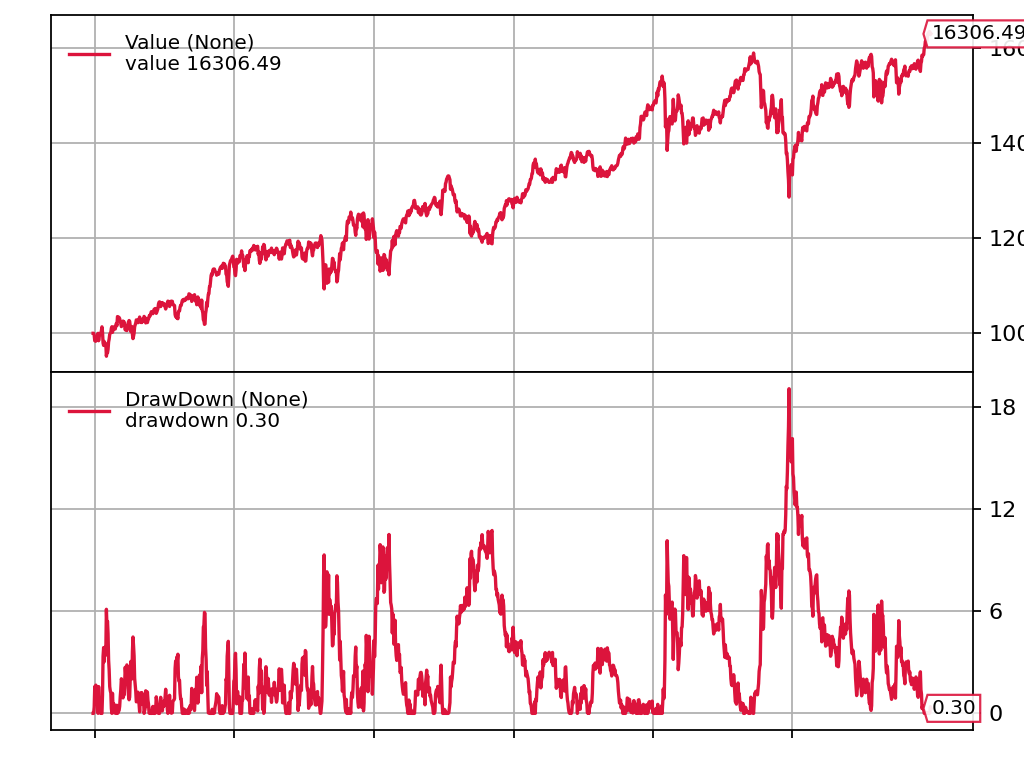

Max Drawdown: 19.08%
CAGR: 5.02%
Sharpe: 0.588


In [60]:
assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices, AssetAllocation, plot=True)
print(f"Max Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

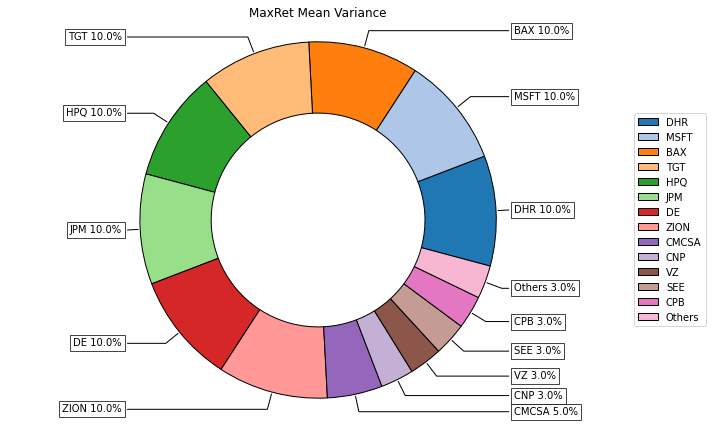

In [66]:
import riskfolio.PlotFunctions as plf
# Plotting the composition of the last portfolio

w = pd.DataFrame(models['MV'].iloc[-1,:])
ax = plf.plot_pie(w=w, title='MaxRet Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

In [67]:
# Composition per Industry

w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)
w_classes = w_classes.groupby(['Industry']).sum()
w_classes.columns = ['weights']
display(w_classes.T)

Industry,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Telecommunications Services,Utilities
weights,15.0000%,3.0000%,3.0000%,20.0000%,10.0000%,20.0000%,20.0000%,3.0000%,3.0000%,3.0000%


# [Using Black Litterman](https://nbviewer.jupyter.org/github/dcajasn/Riskfolio-Lib/blob/master/examples/Tutorial%203.ipynb)

## Returns

In [25]:
returns

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2.6170%,-0.6646%,1.5050%,1.2228%,0.0689%,0.2071%,3.6421%,-0.0665%,1.8249%,1.6536%,...,1.5420%,2.8082%,0.8453%,0.9374%,-1.6206%,0.7319%,0.3721%,1.2227%,0.4528%,3.8972%
2010-01-05,1.1807%,-0.6862%,-1.5607%,-1.3553%,-0.7576%,0.1771%,-0.3746%,-0.1198%,0.4194%,-0.4963%,...,0.0323%,2.5949%,-0.2579%,1.8028%,0.8237%,-1.0445%,0.3708%,-1.8908%,0.1803%,3.5259%
2010-01-06,1.5683%,0.3455%,-0.0396%,-0.7169%,-0.9715%,-1.1199%,-0.2686%,0.1865%,-0.9304%,-0.3325%,...,-0.6137%,0.9452%,-1.1635%,1.3148%,-0.6066%,-1.9275%,1.9085%,3.4797%,-2.8754%,8.6956%
2010-01-07,-1.5165%,1.6181%,0.0793%,2.1059%,0.9811%,-1.5201%,0.7181%,0.8244%,0.0384%,0.7228%,...,-1.0400%,-1.3451%,-1.2426%,1.3242%,-0.1369%,1.0295%,1.2283%,4.4490%,-0.5953%,11.2000%
2010-01-08,-0.5226%,0.2372%,-1.6640%,-0.2946%,-1.1797%,-0.6356%,2.7273%,1.3981%,0.7471%,0.3313%,...,0.6897%,0.6149%,-0.5298%,0.1307%,-1.8207%,0.4169%,-0.3978%,0.9411%,0.0630%,-1.6187%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-1.3570%,0.2011%,-0.0791%,0.9750%,0.1122%,0.2443%,-0.3142%,0.0653%,0.1459%,-0.2184%,...,-0.0191%,1.2757%,-0.0729%,-0.0754%,-0.1760%,-0.3956%,0.1636%,-1.1630%,-0.1954%,0.3701%
2019-12-26,0.3821%,-0.4251%,1.2666%,0.9881%,0.5605%,-0.4266%,0.1719%,-0.2285%,0.4857%,-0.0243%,...,0.8197%,0.6501%,-0.2917%,0.0252%,0.7148%,-0.0745%,0.2645%,0.0222%,0.0163%,0.2523%
2019-12-27,-0.5710%,-0.3320%,0.2814%,0.2891%,0.0000%,0.8976%,0.5778%,0.0393%,-0.7733%,-0.1216%,...,0.1828%,-0.6056%,-0.2194%,-0.1258%,0.1325%,-0.7950%,0.2483%,-1.5316%,0.3916%,-0.3097%


## Calculating a reference portfolio

In [69]:
# Building the portfolio object
port = pf.Portfolio(returns=returns)


# Add portfolio constraints #here I use before's things
port.ainequality = A
port.binequality = B

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MaxRet' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
# l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, hist=hist)

display(w.T)

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
weights,0.0000%,0.0000%,3.0000%,10.0000%,0.0000%,0.0000%,0.0000%,10.0000%,0.0000%,7.9988%,...,10.0000%,3.0000%,10.0000%,0.0000%,0.0000%,3.0000%,0.0012%,0.0000%,3.0000%,10.0000%


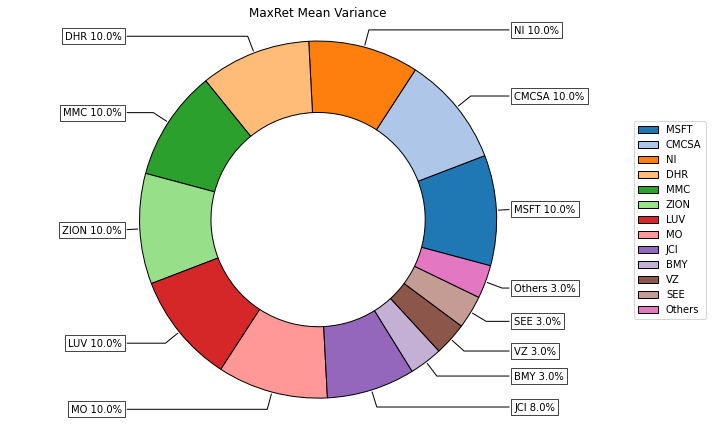

In [70]:
# Plotting the composition of the portfolio

ax = plf.plot_pie(w=w, title='MaxRet Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)


## Plotting portfolio composition

### Create views

In [71]:
asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','NBL','APA','MMC',
                            'JPM','ZION','PSA','BAX','BMY','LUV','PCAR',
                            'TXT','DHR','DE','MSFT','HPQ','SEE','VZ','CNP','NI'], 
                 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Industrials','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities'] }

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

views = {'Disabled': [False, False, False],
         'Type': ['Classes', 'Classes', 'Classes'],
         'Set': ['Industry', 'Industry', 'Industry'],
         'Position': ['Energy', 'Consumer Staples', 'Materials'],
         'Sign': ['>=', '>=', '>='],
         'Weight': [0.08, 0.1, 0.09], # Anual terms 
         'Type Relative': ['Classes', 'Classes', 'Classes'],
         'Relative Set': ['Industry', 'Industry', 'Industry'],
         'Relative': ['Financials', 'Utilities', 'Industrials']}

views = pd.DataFrame(views)

display(views)


,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Industry,Energy,>=,8.0000%,Classes,Industry,Financials
1,False,Classes,Industry,Consumer Staples,>=,10.0000%,Classes,Industry,Utilities
2,False,Classes,Industry,Materials,>=,9.0000%,Classes,Industry,Industrials


> Energy will outperform Financials by 8% 

> Consumer Staples will outperform Utillities by 10% 

> Materials will outperform Industrials by 9%

In [72]:
P, Q = cf.assets_views(views, asset_classes)

display(pd.DataFrame(P.T))
display(pd.DataFrame(Q))

,0,1,2
0,50.0000%,0.0000%,0.0000%
1,0.0000%,0.0000%,0.0000%
2,0.0000%,0.0000%,0.0000%
3,0.0000%,0.0000%,0.0000%
4,0.0000%,-50.0000%,0.0000%
5,0.0000%,50.0000%,0.0000%
6,0.0000%,0.0000%,-20.0000%
7,0.0000%,0.0000%,-20.0000%
8,0.0000%,0.0000%,0.0000%
9,0.0000%,0.0000%,0.0000%


,0
0,8.0000%
1,10.0000%
2,9.0000%


In [73]:
# Estimate Black Litterman inputs:

port.blacklitterman_stats(P, Q/252, rf=rf, w=w, delta=None, eq=True)

# Estimate optimal portfolio:

model='BL'# Black Litterman
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios

w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_bl.T)

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
weights,1.0948%,0.0000%,3.1854%,9.1063%,0.0000%,10.0000%,0.0000%,6.7903%,0.0000%,6.9820%,...,9.1667%,4.4263%,3.0000%,0.0000%,0.0000%,10.0000%,1.0631%,0.0000%,4.0334%,7.5821%


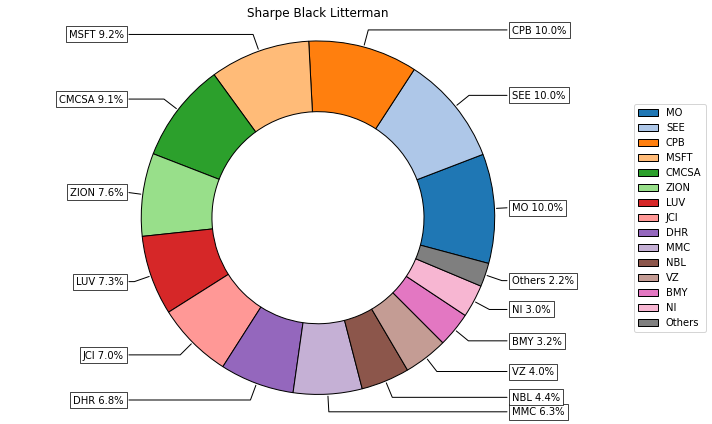

In [74]:
# Plotting the composition of the portfolio

ax = plf.plot_pie(w=w_bl, title='Sharpe Black Litterman', others=0.05, nrow=24,
                  cmap = "tab20", height=6, width=10, ax=None)


## Calculate efficient frontier

In [75]:
points = 100 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BAX,BMY,CMCSA,CNP,CPB,DE,DHR,HPQ,JCI,...,MSFT,NBL,NI,PCAR,PSA,SEE,TGT,TXT,VZ,ZION
0,1.6675%,7.8198%,7.7277%,1.2353%,8.0236%,10.0000%,0.6346%,0.5625%,0.0000%,1.5354%,...,3.0000%,1.3325%,10.0000%,0.0000%,4.4525%,3.0000%,10.0000%,0.0000%,10.0000%,0.0000%
1,1.4230%,7.8178%,7.6276%,2.8054%,5.3538%,10.0000%,0.0000%,0.7407%,0.0000%,3.1710%,...,3.3664%,1.5770%,8.7532%,0.0000%,4.5545%,3.0000%,9.1579%,0.0000%,10.0000%,0.0000%
2,1.3153%,7.7503%,7.5885%,3.4087%,4.3792%,10.0000%,0.0000%,0.6604%,0.0000%,3.7936%,...,3.9220%,1.6847%,8.0039%,0.0000%,4.6612%,3.0000%,8.6951%,0.0000%,10.0000%,0.0000%
3,1.2424%,7.6977%,7.5643%,3.8028%,3.6696%,10.0000%,0.0000%,0.7603%,0.0000%,4.1882%,...,4.2703%,1.7576%,7.4538%,0.0000%,4.7380%,3.0000%,8.3405%,0.0000%,10.0000%,0.0000%
4,1.1899%,7.6517%,7.5490%,4.0724%,3.0999%,10.0000%,0.0000%,1.0018%,0.0000%,4.4449%,...,4.4944%,1.8101%,7.0070%,0.0000%,4.7993%,3.0000%,8.0375%,0.0000%,10.0000%,0.0000%


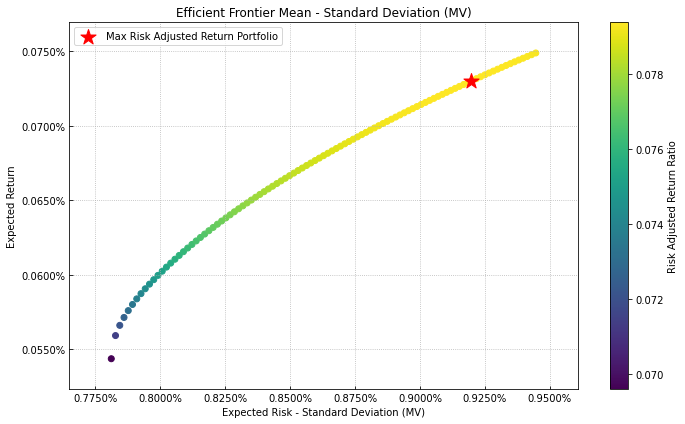

In [76]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu_bl # Expected returns of Black Litterman model
cov = port.cov_bl # Covariance matrix of Black Litterman model
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.01, cmap='viridis', w=w_bl, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

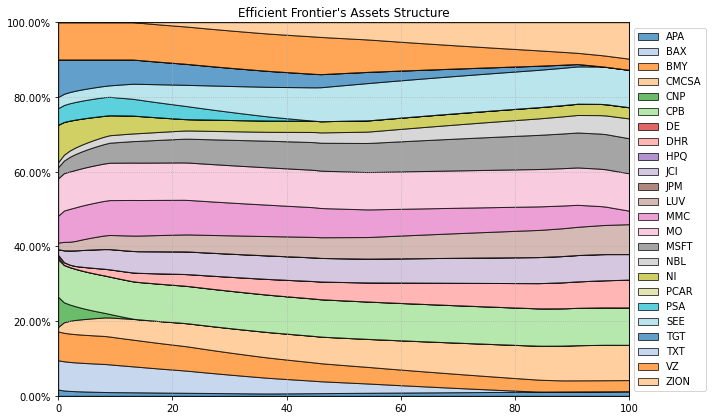

In [77]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## Estimating Black Litterman Mean Risk Portfolios¶
When we use risk measures differents than Standard Deviation, Riskfolio-Lib only considers the vector of expected returns, and use historical returns to calculate risk measures.

### Calculate Black Litterman Portfolios for Several Risk Measures

In [78]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

w_s = pd.DataFrame([])

for i in rms:
    if i == 'MV':
        hist = False
    else:
        hist = True
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [79]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,WR,MDD,ADD,CDaR
APA,1.09%,2.81%,2.41%,0.00%,0.00%,0.00%,10.00%,0.00%,0.00%,0.00%
BAX,0.00%,1.95%,1.38%,3.15%,0.00%,0.00%,0.00%,0.00%,3.55%,0.00%
BMY,3.19%,3.85%,2.86%,4.83%,3.24%,4.52%,10.00%,1.55%,0.00%,7.90%
CMCSA,9.11%,4.80%,9.93%,5.60%,7.72%,9.99%,0.00%,10.00%,2.59%,3.00%
CNP,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.20%,10.00%
CPB,10.00%,9.04%,10.00%,6.37%,10.00%,10.00%,10.00%,10.00%,0.00%,9.05%
DE,0.00%,0.00%,0.00%,0.40%,0.00%,0.00%,0.00%,3.00%,10.00%,8.05%
DHR,6.79%,9.46%,4.98%,10.00%,10.00%,10.00%,0.00%,0.00%,10.00%,0.00%
HPQ,0.00%,1.67%,2.09%,0.00%,0.00%,3.98%,10.00%,0.15%,0.00%,0.00%
JCI,6.98%,6.06%,6.85%,5.67%,6.28%,0.00%,0.00%,0.00%,0.00%,0.00%


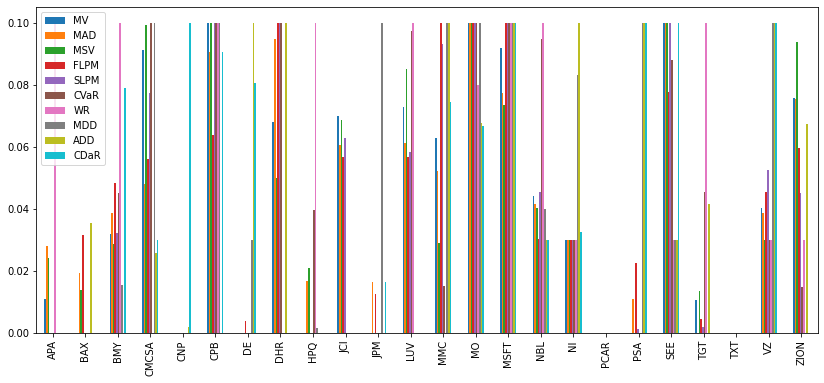

In [80]:


# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## Try Backtesting with Black Litterman

In [ ]:
weights = pd.DataFrame([])

for i in index_:
    Y = returns[i-500:i] # taking last 2 years (250 trading days per year)

    # Building the portfolio object
    port = pf.Portfolio(returns=Y)

    # Estimate Black Litterman inputs:

    port.blacklitterman_stats(P, Q/252, rf=rf, w=w, delta=None, eq=True)

    # Estimate optimal portfolio:

    # Estimate optimal portfolio:

    model='BL'# Black Litterman
    rm = 'MV' # Risk measure used, this time will be variance
    obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = False # Use historical scenarios for risk measures that depend on scenarios

    w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

    if w_bl is None:
        w_bl = weights.tail(1).T
    weights = pd.concat([weights, w_bl.T], axis = 0)

model_BL = weights.copy()
model_BL.index = index_